Para este estudo de caso usaremos o dataset NSL-KDD: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

Este é o conjunto de dados usado para a Terceira Competição Internacional de Ferramentas de Descoberta de Conhecimento e Ferramentas de Mineração de Dados, realizada em conjunto com a KDD-99, A Quinta Conferência Internacional sobre Descoberta de Conhecimento e Mineração de Dados. A tarefa da competição era construir um detector de intrusão de rede, um modelo preditivo capaz de distinguir entre conexões "ruins", chamadas intrusões ou ataques, e "boas" conexões normais. Este banco de dados contém um conjunto padrão de dados a serem auditados, que inclui uma ampla variedade de intrusões simuladas em um ambiente de rede militar.

O conjunto de dados NSL-KDD possui 42 atributos para cada registro de conexão, incluindo rótulo de classe contendo tipos de ataque. Os tipos de ataque são categorizados em quatro classes de ataque, conforme descrito neste paper [Uma análise detalhada do conjunto de dados KDD CUP 99] (http://www.ee.ryerson.ca/~bagheri/papers/cisda.pdf) como:

1. **Denial of Service (DoS)**: é um ataque no qual um adversário direcionou uma enxurrada de solicitações de tráfego para um sistema a fim de tornar o recurso de computação ou memória muito ocupado ou muito cheio para lidar com solicitações legítimas e no processo, nega o acesso de usuários legítimos a uma máquina.

2. **Probing Attack (Probe)**: investiga a rede de computadores para coletar informações a serem usadas para comprometer seus controles de segurança.

3. **User to Root Attack (U2R)**: uma classe de exploit na qual o adversário começa com acesso a uma conta de usuário normal no sistema (obtida por senhas sniffing, ataque de dicionário ou engenharia social) e é capaz de explorar alguma vulnerabilidade para obter acesso root ao sistema.

4. **Remote to Local Attack (R2L)**: ocorre quando um invasor que tem a capacidade de enviar pacotes para uma máquina através de uma rede, mas que não possui uma conta nessa máquina, explora alguma vulnerabilidade para obter acesso local como usuário dessa máquina.

In [1]:
!pip install imblearn

In [2]:
# Imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Versões das principais bibliotecas
print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 0.24.2
numpy : 1.16.2
matplotlib : 3.0.3
seaborn : 0.9.0
sklearn : 0.20.3
imblearn : 0.4.3


## Carregando os Dados

In [3]:
# Nomes das colunas
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Carregando os dados de treino
dfkdd_train = pd.read_csv("data/KDDTrain.txt", sep=",", names=datacols) 

# Remove um campo extra indesejado
dfkdd_train = dfkdd_train.iloc[:,:-1] 

# Carregando os dados de teste
dfkdd_test = pd.read_csv("data/KDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

### Definindo os Dados de Treino

In [4]:
dfkdd_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
7,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
9,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [5]:
dfkdd_train.attack.unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [6]:
print('Dimensões dos dados de treino: {} linhas, {} colunas'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Dimensões dos dados de treino: 125973 linhas, 42 colunas


### Definindo os Dados de Teste

In [7]:
dfkdd_test.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,mscan
5,0,tcp,http,SF,267,14515,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00,normal
6,0,tcp,smtp,SF,1022,387,0,0,0,0,...,28,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04,normal
7,0,tcp,telnet,SF,129,174,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,guess_passwd
8,0,tcp,http,SF,327,467,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,normal
9,0,tcp,ftp,SF,26,157,0,0,0,0,...,26,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00,guess_passwd


In [8]:
print('Dimensões dos dados de teste: {} linhas, {} colunas'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Dimensões dos dados de teste: 22544 linhas, 42 colunas


## Processamento dos Dados

In [9]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [10]:
# Aplicar mapeamentos de classes de ataque ao conjunto de dados
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])


dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [11]:
# Drop do campo de ataque dos dados de treino e teste
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [12]:
# Veja os 3 principais dados de treino
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


## Análise Exploratória de Dados

In [13]:
# Estatísticas descritivas
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
dfkdd_train['num_outbound_cmds'].value_counts()
dfkdd_test['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

In [15]:
# A coluna 'num_outbound_cmds' tem todos os valores 0. 
# Portanto, ela será removido do conjunto de dados de treino e de teste, pois é um campo redundante.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [16]:
# Distribuição de Classes de Ataque
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1, sort=True) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
DoS,45927,36.46,7458,33.08
Normal,67343,53.46,9711,43.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


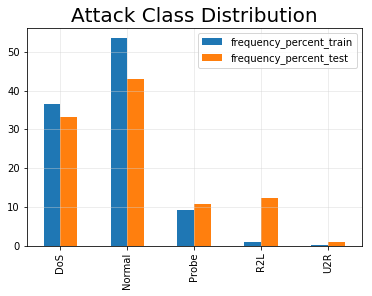

In [17]:
# Barplot das Classes de Ataque
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [18]:
dfkdd_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


## Padronizando Atributos Numéricos

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Extrair atributos numéricos e dimensioná-los para ter média zero e variação unitária
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# Transformar o resultado de volta em um dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

## Encoding de Atributos Categóricos

In [20]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Extrair atributos categóricos de conjuntos de treinamento e teste
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# Encoding dos atributos categóricos
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# Coluna de destino separada dos dados codificados
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

## Amostragem e Balanceamento

In [21]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# Definir colunas e extrair conjunto de treino codificado para amostragem
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# Remodele a coluna de destino para a forma da matriz 1D
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# Aplicar a super amostragem aleatória
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)

print('Forma original do conjunto de dados {}'.format(Counter(y)))
print('Forma de conjunto de dados reamostrada {}'.format(Counter(y_res)))

Forma original do conjunto de dados Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Forma de conjunto de dados reamostrada Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


### Feature Selection

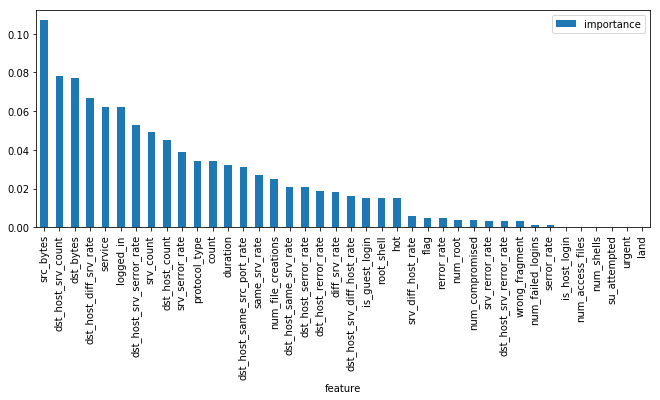

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# Classificador Random Forest no conjunto de treinamento
rfc.fit(X_res, y_res);

# Extrair características importantes
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# Plot 
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [23]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# Cria o modelo de RFE e seleciona 10 atributos
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)

# Sumariza a seleção dos atributos
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
selected_features = [v for i, v in feature_map if i==True]

In [24]:
print(selected_features)

['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'service']


## Particionamento dos Dados

In [25]:
# Definir colunas para novo dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# Adicionar uma dimensão ao destino
new_y_res = y_res[:, np.newaxis]

# Cria um dataframe a partir dos dados da amostra
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 

# Cria dataframe de teste
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

(22544, 41)

In [26]:
from collections import defaultdict
classdict = defaultdict(list)

# Criar duas classes de destino (classe normal e uma classe de ataque)
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    '''Esta função subdivide o conjunto de dados de treino e teste em rótulos de ataque de duas classes''' 
    for j, k in normalclass: 
        for i, v in attacklist: 
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            
            # Labels de teste
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)
        
create_classdict()

In [27]:
for k, v in classdict.items():
    k

In [28]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

## Finaliza o pré-processamento de dados para treinamento

In [29]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

Xresdf = pretrain 
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit dados de treino
enc.fit(Xresdfcat)

# Transforma os dados de treino
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
       
# Transforma os dados de teste
X_test_1hotenc = enc.transform(Xtestcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1) 

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

## Treinamento do Modelo SVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [30]:
from sklearn.svm import SVC 

# Cria o classificador
SVC_Classifier = SVC(random_state=0)

# Treinamento (fit)
SVC_Classifier.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

## Avaliação do Modelo

In [31]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

models = []
models.append(('Classificador SVM', SVC_Classifier))


for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Avaliação do Modelo =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Acurácia do Modelo:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Relatório de Classificação:" "\n", classification) 
    print()


============================== Normal_DoS Classificador SVM Avaliação do Modelo ==============================

Cross Validation Mean Score:
 0.9849501945715753

Acurácia do Modelo:
 0.9849650297729534

Confusion matrix:
 [[65904  1439]
 [  586 66757]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     67343
         1.0       0.98      0.99      0.99     67343

   micro avg       0.98      0.98      0.98    134686
   macro avg       0.99      0.98      0.98    134686
weighted avg       0.99      0.98      0.98    134686




## Testando o Modelo

In [32]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} {} Testando o Modelo =============================='.format(grpclass, i))
    print()
    print ("Acurácia do Modelo:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Relatório de Classificação:" "\n", classification) 
    print()        



============================== Normal_DoS Classificador SVM Testando o Modelo ==============================

Acurácia do Modelo:
 0.8551459024986895

Confusion matrix:
 [[5802 1656]
 [ 831 8880]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      0.78      0.82      7458
         1.0       0.84      0.91      0.88      9711

   micro avg       0.86      0.86      0.86     17169
   macro avg       0.86      0.85      0.85     17169
weighted avg       0.86      0.86      0.85     17169




# Fim